"""
===============================================================================
МОДЕЛЬ ПРОГНОЗИРОВАНИЯ ОТТОКА КЛИЕНТОВ БАНКА (CHURN PREDICTION MODEL)
===============================================================================

Полный воспроизводимый пайплайн построения моделей

Дата: 2025-01-13
Версия: 1.0
Алгоритм: CatBoost Classifier

ОСОБЕННОСТИ:
- Две модели по сегментам:
  * Модель 1: Малый бизнес (SMALL_BUSINESS)
  * Модель 2: Средний + Крупный бизнес (MIDDLE + LARGE_BUSINESS)
- Temporal Split (Train/Val/Test-OOT)
- Обработка дисбаланса классов
- Полная воспроизводимость (random_seed=42)

МЕТРИКИ:
- GINI coefficient
- ROC-AUC
- PR-AUC
- Accuracy, Precision, Recall, F1-Score
- Confusion Matrix

===============================================================================
"""


# 1. ИМПОРТ БИБЛИОТЕК И КОНФИГУРАЦИЯ


In [2]:
# ====================================================================================
# ИМПОРТ БИБЛИОТЕК
# ====================================================================================

import os
import sys
import warnings
from datetime import datetime
from pathlib import Path
import json
import pickle
import time
import gc

# Данные
import numpy as np
import pandas as pd
from scipy import stats

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_score, recall_score
)

# Настройки
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("="*80)
print("CHURN PREDICTION MODEL - ПОЛНЫЙ ПАЙПЛАЙН")
print("="*80)
print(f"✓ Библиотеки импортированы")
print(f"  Pandas: {pd.__version__}")
print(f"  NumPy: {np.__version__}")
print(f"  Дата запуска: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)


CHURN PREDICTION MODEL - ПОЛНЫЙ ПАЙПЛАЙН
✓ Библиотеки импортированы
  Pandas: 2.2.2
  NumPy: 1.26.4
  Дата запуска: 2025-11-13 20:52:36


In [3]:
# ====================================================================================
# ГЛОБАЛЬНАЯ КОНФИГУРАЦИЯ
# ====================================================================================

class Config:
    """Централизованная конфигурация для воспроизводимости"""

    # ВОСПРОИЗВОДИМОСТЬ
    RANDOM_SEED = 42

    # ПУТИ
    DATA_DIR = Path("data")
    OUTPUT_DIR = Path("output")
    MODEL_DIR = Path("models")
    FIGURES_DIR = Path("figures")

    # ФАЙЛЫ
    TRAIN_FILE = "churn_train_ul.parquet"
    PROD_FILE = "churn_prod_ul.parquet"

    # КОЛОНКИ
    ID_COLUMNS = ['cli_code', 'client_id', 'observation_point']
    TARGET_COLUMN = 'target_churn_3m'
    SEGMENT_COLUMN = 'segment_group'
    DATE_COLUMN = 'observation_point'
    CATEGORICAL_FEATURES = ['segment_group', 'obs_month', 'obs_quarter']

    # СЕГМЕНТЫ (ДВЕ МОДЕЛИ)
    SEGMENT_1_NAME = "Small Business"
    SEGMENT_1_VALUES = ['SMALL_BUSINESS']

    SEGMENT_2_NAME = "Middle + Large Business"
    SEGMENT_2_VALUES = ['MIDDLE_BUSINESS', 'LARGE_BUSINESS']

    # ВРЕМЕННОЕ РАЗБИЕНИЕ
    TRAIN_SIZE = 0.70
    VAL_SIZE = 0.15
    TEST_SIZE = 0.15

    # PREPROCESSING
    CORRELATION_THRESHOLD = 0.85
    OUTLIER_IQR_MULTIPLIER = 1.5
    REMOVE_GAPS = True
    HANDLE_OUTLIERS = True
    REMOVE_HIGH_CORRELATIONS = True

    # CATBOOST
    CATBOOST_PARAMS = {
        'iterations': 500,
        'learning_rate': 0.05,
        'depth': 4,
        'l2_leaf_reg': 3,
        'min_data_in_leaf': 100,
        'random_strength': 1,
        'bagging_temperature': 1,
        'border_count': 128,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'early_stopping_rounds': 100,
        'use_best_model': True,
        'random_seed': 42,
        'task_type': 'CPU',
        'verbose': 100,
        'allow_writing_files': False
    }

    # IMBALANCE
    USE_CLASS_WEIGHTS = True
    TUNE_THRESHOLD = True
    THRESHOLD_METRIC = 'f1'

    @classmethod
    def create_directories(cls):
        for dir_path in [cls.OUTPUT_DIR, cls.MODEL_DIR, cls.FIGURES_DIR]:
            dir_path.mkdir(parents=True, exist_ok=True)

    @classmethod
    def get_train_path(cls):
        return cls.DATA_DIR / cls.TRAIN_FILE

config = Config()
config.create_directories()
np.random.seed(config.RANDOM_SEED)

print("\\n✓ Конфигурация инициализирована")
print(f"  Random seed: {config.RANDOM_SEED}")
print(f"  Модель 1: {config.SEGMENT_1_NAME} {config.SEGMENT_1_VALUES}")
print(f"  Модель 2: {config.SEGMENT_2_NAME} {config.SEGMENT_2_VALUES}")
print(f"  Split: {config.TRAIN_SIZE}/{config.VAL_SIZE}/{config.TEST_SIZE}")


\n✓ Конфигурация инициализирована
  Random seed: 42
  Модель 1: Small Business ['SMALL_BUSINESS']
  Модель 2: Middle + Large Business ['MIDDLE_BUSINESS', 'LARGE_BUSINESS']
  Split: 0.7/0.15/0.15


---
# 2. ЗАГРУЗКА ДАННЫХ (PARQUET)


In [4]:
# ====================================================================================
# ЗАГРУЗКА ДАННЫХ
# ====================================================================================

train_path = config.get_train_path()

print("\\n" + "="*80)
print("ЗАГРУЗКА ДАННЫХ")
print("="*80)
print(f"Файл: {train_path}")

if not train_path.exists():
    raise FileNotFoundError(
        f"Файл не найден: {train_path}\\n"
        f"Запустите: python csv_to_parquet_converter.py"
    )

file_size = train_path.stat().st_size / (1024**2)
print(f"Размер: {file_size:.2f} MB")

start = time.time()
df_full = pd.read_parquet(train_path)
load_time = time.time() - start

memory = df_full.memory_usage(deep=True).sum() / (1024**2)

print(f"\\n✓ Загружено за {load_time:.2f} сек")
print(f"  Размер: {df_full.shape}")
print(f"  Память: {memory:.2f} MB")

# Целевая переменная
churn_rate = df_full[config.TARGET_COLUMN].mean()
print(f"\\n  Target '{config.TARGET_COLUMN}':")
print(f"    Churn rate: {churn_rate:.4f} ({churn_rate*100:.2f}%)")
print(f"    Churned: {df_full[config.TARGET_COLUMN].sum():,}")
print(f"    Ratio: 1:{(1-churn_rate)/churn_rate:.1f}")

# Временной диапазон
df_full[config.DATE_COLUMN] = pd.to_datetime(df_full[config.DATE_COLUMN])
print(f"\\n  Период: {df_full[config.DATE_COLUMN].min().date()} - "
      f"{df_full[config.DATE_COLUMN].max().date()}")
print(f"  Уникальных дат: {df_full[config.DATE_COLUMN].nunique()}")

# Сегменты
print(f"\\n  Распределение по сегментам:")
for segment, count in df_full[config.SEGMENT_COLUMN].value_counts().items():
    pct = count / len(df_full) * 100
    churn_seg = df_full[df_full[config.SEGMENT_COLUMN]==segment][config.TARGET_COLUMN].mean()
    print(f"    {segment}: {count:,} ({pct:.1f}%) | Churn: {churn_seg*100:.2f}%")

print("="*80)


\n================================================================================
ЗАГРУЗКА ДАННЫХ
Файл: data\churn_train_ul.parquet
Размер: 747.39 MB
\n✓ Загружено за 1.79 сек
  Размер: (3243871, 195)
  Память: 2094.37 MB
\n  Target 'target_churn_3m':
    Churn rate: 0.0150 (1.50%)
    Churned: 48,708
    Ratio: 1:65.6
\n  Период: 2023-06-30 - 2025-06-30
  Уникальных дат: 25
\n  Распределение по сегментам:
    SMALL_BUSINESS: 3,032,498 (93.5%) | Churn: 1.56%
    MIDDLE_BUSINESS: 189,911 (5.9%) | Churn: 0.59%
    LARGE_BUSINESS: 21,462 (0.7%) | Churn: 0.68%


---
# 3. EXPLORATORY DATA ANALYSIS (EDA)


In [5]:
# ====================================================================================
# АНАЛИЗ КАЧЕСТВА ДАННЫХ
# ====================================================================================

print("\\n" + "="*80)
print("АНАЛИЗ КАЧЕСТВА ДАННЫХ")
print("="*80)

# Пропуски
missing = df_full.isnull().sum()
missing_df = pd.DataFrame({
    'Missing': missing[missing > 0],
    'Percent': (missing[missing > 0] / len(df_full) * 100).round(2)
}).sort_values('Missing', ascending=False)

print(f"\\n1. Пропущенные значения:")
if len(missing_df) > 0:
    print(f"   {len(missing_df)} колонок с пропусками:")
    print(missing_df.head(10).to_string())
else:
    print("   ✓ Нет пропусков")

# Константы
constant_cols = [col for col in df_full.columns if df_full[col].nunique() == 1]
print(f"\\n2. Константные колонки: {len(constant_cols)}")
if constant_cols:
    print(f"   {constant_cols[:5]}...")

# Дубликаты
n_dups = df_full.duplicated().sum()
print(f"\\n3. Дубликаты: {n_dups:,}")

# Типы
print(f"\\n4. Типы данных:")
for dtype, count in df_full.dtypes.value_counts().items():
    print(f"   {dtype}: {count}")

# Категориальные
cat_cols = df_full.select_dtypes(include='category').columns
print(f"\\n5. Категориальные: {len(cat_cols)}")
for col in cat_cols:
    print(f"   {col}: {df_full[col].nunique()} unique")

print("="*80)


\n================================================================================
АНАЛИЗ КАЧЕСТВА ДАННЫХ
\n1. Пропущенные значения:
   ✓ Нет пропусков
\n2. Константные колонки: 9
   ['obs_months_count', 'total_lending_ebrd_pl_6m', 'total_bonds_pl_6m', 'avg_deposits_liabilities_6m', 'avg_guarantees_liabilities_6m']...
\n3. Дубликаты: 0
\n4. Типы данных:
   float32: 125
   int8: 62
   int64: 5
   datetime64[ns]: 1
   category: 1
   int16: 1
\n5. Категориальные: 1
   segment_group: 3 unique


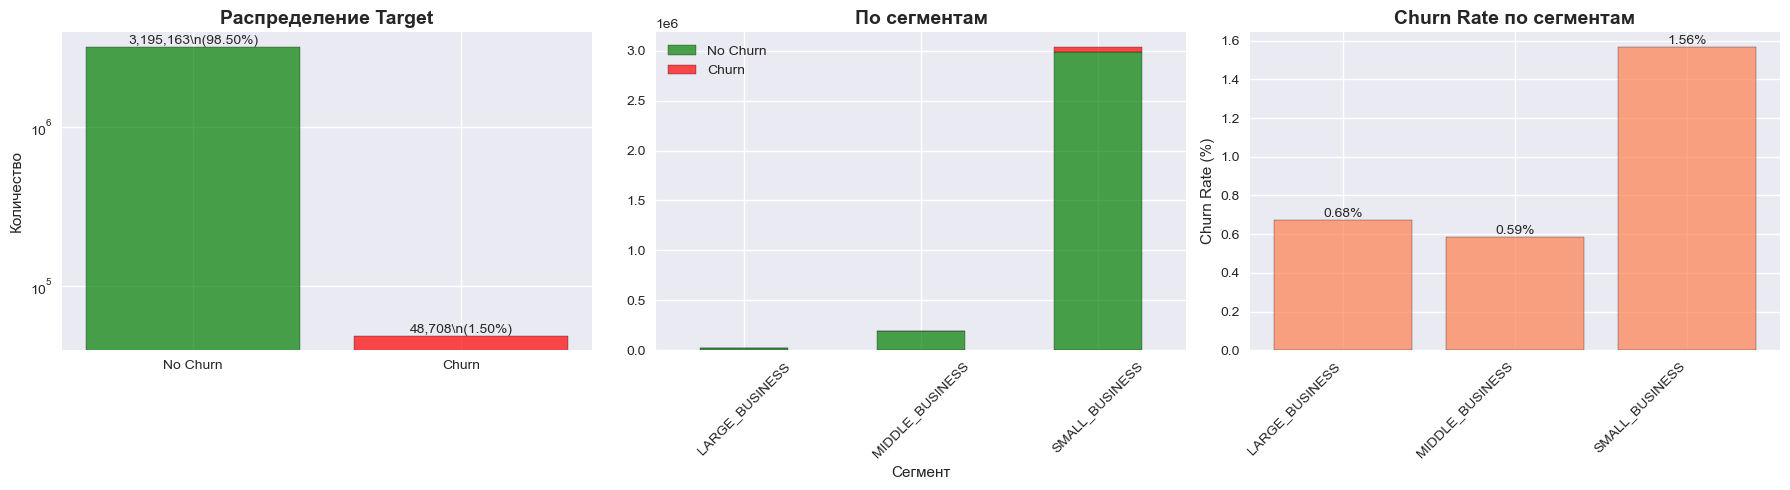

✓ Сохранено: figures/01_eda_target.png


In [6]:
# ====================================================================================
# ВИЗУАЛИЗАЦИЯ: РАСПРЕДЕЛЕНИЕ TARGET
# ====================================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Общее
target_dist = df_full[config.TARGET_COLUMN].value_counts()
axes[0].bar(['No Churn', 'Churn'], [target_dist[0], target_dist[1]],
           color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0].set_title('Распределение Target', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Количество')
axes[0].set_yscale('log')
for i, v in enumerate([target_dist[0], target_dist[1]]):
    axes[0].text(i, v, f'{v:,}\\n({v/len(df_full)*100:.2f}%)',
                ha='center', va='bottom')

# 2. По сегментам
segment_churn = df_full.groupby([config.SEGMENT_COLUMN,
                                  config.TARGET_COLUMN]).size().unstack(fill_value=0)
segment_churn.plot(kind='bar', stacked=True, ax=axes[1],
                  color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_title('По сегментам', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Сегмент')
axes[1].legend(['No Churn', 'Churn'])
axes[1].tick_params(axis='x', rotation=45)

# 3. Churn rate
churn_rates = df_full.groupby(config.SEGMENT_COLUMN)[config.TARGET_COLUMN].mean() * 100
axes[2].bar(range(len(churn_rates)), churn_rates.values,
           color='coral', alpha=0.7, edgecolor='black')
axes[2].set_xticks(range(len(churn_rates)))
axes[2].set_xticklabels(churn_rates.index, rotation=45, ha='right')
axes[2].set_title('Churn Rate по сегментам', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Churn Rate (%)')
for i, v in enumerate(churn_rates.values):
    axes[2].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / '01_eda_target.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Сохранено: figures/01_eda_target.png")


---
# 4. ВРЕМЕННОЕ РАЗБИЕНИЕ (TRAIN / VAL / TEST-OOT)

Разбиение по времени для предотвращения data leakage.
**OOT (Out-of-Time)** - тестовая выборка из будущих периодов.


In [7]:
# ====================================================================================
# TEMPORAL SPLIT
# ====================================================================================

print("\\n" + "="*80)
print("ВРЕМЕННОЕ РАЗБИЕНИЕ (TEMPORAL SPLIT)")
print("="*80)

# Сортировка по времени
df_sorted = df_full.sort_values(config.DATE_COLUMN).reset_index(drop=True)
unique_dates = sorted(df_sorted[config.DATE_COLUMN].unique())
n_dates = len(unique_dates)

print(f"\\nУникальных дат: {n_dates}")
print(f"Период: {unique_dates[0].date()} - {unique_dates[-1].date()}")

# Cutoff indices
train_cutoff = int(n_dates * config.TRAIN_SIZE)
val_cutoff = int(n_dates * (config.TRAIN_SIZE + config.VAL_SIZE))

train_end = unique_dates[train_cutoff - 1]
val_end = unique_dates[val_cutoff - 1]

print(f"\\nCutoff даты:")
print(f"  Train: до {train_end.date()} ({train_cutoff} дат)")
print(f"  Val: {unique_dates[train_cutoff].date()} - {val_end.date()} ({val_cutoff - train_cutoff} дат)")
print(f"  Test (OOT): {unique_dates[val_cutoff].date()}+ ({n_dates - val_cutoff} дат)")

# Создание split
train_df = df_sorted[df_sorted[config.DATE_COLUMN] <= train_end].copy()
val_df = df_sorted[(df_sorted[config.DATE_COLUMN] > train_end) &
                   (df_sorted[config.DATE_COLUMN] <= val_end)].copy()
test_df = df_sorted[df_sorted[config.DATE_COLUMN] > val_end].copy()

# Stats
for name, df in [('TRAIN', train_df), ('VAL', val_df), ('TEST (OOT)', test_df)]:
    churn_r = df[config.TARGET_COLUMN].mean()
    print(f"\\n{name}:")
    print(f"  Записей: {len(df):,}")
    print(f"  Клиентов: {df['cli_code'].nunique():,}")
    print(f"  Период: {df[config.DATE_COLUMN].min().date()} - {df[config.DATE_COLUMN].max().date()}")
    print(f"  Churn rate: {churn_r:.4f} ({churn_r*100:.2f}%)")

# Проверка leakage
assert train_df[config.DATE_COLUMN].max() < val_df[config.DATE_COLUMN].min()
assert val_df[config.DATE_COLUMN].max() < test_df[config.DATE_COLUMN].min()
print("\\n✓ Temporal ordering verified - no data leakage")

print("="*80)


\n================================================================================
ВРЕМЕННОЕ РАЗБИЕНИЕ (TEMPORAL SPLIT)
\nУникальных дат: 25
Период: 2023-06-30 - 2025-06-30
\nCutoff даты:
  Train: до 2024-10-31 (17 дат)
  Val: 2024-11-30 - 2025-02-28 (4 дат)
  Test (OOT): 2025-03-31+ (4 дат)
\nTRAIN:
  Записей: 2,162,862
  Клиентов: 173,448
  Период: 2023-06-30 - 2024-10-31
  Churn rate: 0.0144 (1.44%)
\nVAL:
  Записей: 535,263
  Клиентов: 144,022
  Период: 2024-11-30 - 2025-02-28
  Churn rate: 0.0178 (1.78%)
\nTEST (OOT):
  Записей: 545,746
  Клиентов: 146,264
  Период: 2025-03-31 - 2025-06-30
  Churn rate: 0.0145 (1.45%)
\n✓ Temporal ordering verified - no data leakage


---
# 5. УДАЛЕНИЕ КЛИЕНТОВ С ПРОБЕЛАМИ В НАБЛЮДЕНИЯХ


In [8]:
# ====================================================================================
# GAP REMOVAL
# ====================================================================================

if config.REMOVE_GAPS:
    print("\\n" + "="*80)
    print("УДАЛЕНИЕ КЛИЕНТОВ С ПРОБЕЛАМИ")
    print("="*80)

    print("\\nАнализ пробелов в train...")

    # Chunked processing
    unique_clients = train_df['cli_code'].unique()
    chunk_size = 10000
    clients_with_gaps_list = []

    for i in range(0, len(unique_clients), chunk_size):
        chunk_clients = unique_clients[i:i+chunk_size]
        chunk = train_df[train_df['cli_code'].isin(chunk_clients)].copy()
        chunk = chunk.sort_values(['cli_code', config.DATE_COLUMN])

        chunk['month_num'] = chunk[config.DATE_COLUMN].dt.to_period('M').apply(lambda x: x.ordinal)
        chunk['month_diff'] = chunk.groupby('cli_code')['month_num'].diff()

        gaps = chunk.groupby('cli_code')['month_diff'].agg([
            ('max_gap', 'max'),
            ('total_gaps', lambda x: (x > 1).sum())
        ]).reset_index()

        chunk_gaps = gaps[gaps['max_gap'] > 1]
        clients_with_gaps_list.append(chunk_gaps)

        if (i // chunk_size + 1) % 10 == 0:
            gc.collect()
            print(f"  Обработано {i+chunk_size:,}/{len(unique_clients):,} клиентов")

    clients_with_gaps = pd.concat(clients_with_gaps_list, ignore_index=True)

    gap_pct = len(clients_with_gaps) / len(unique_clients) * 100
    print(f"\\nКлиентов с пробелами: {len(clients_with_gaps):,} ({gap_pct:.2f}%)")

    if len(clients_with_gaps) > 0:
        bad_clients = set(clients_with_gaps['cli_code'])

        train_before = len(train_df)
        train_df = train_df[~train_df['cli_code'].isin(bad_clients)].copy()
        val_df = val_df[~val_df['cli_code'].isin(bad_clients)].copy()
        test_df = test_df[~test_df['cli_code'].isin(bad_clients)].copy()

        print(f"\\nУдалено:")
        print(f"  Train: {train_before:,} → {len(train_df):,}")
        print(f"  Val: {len(val_df):,}")
        print(f"  Test: {len(test_df):,}")

        del clients_with_gaps, bad_clients
        gc.collect()

    print("="*80)


\n================================================================================
УДАЛЕНИЕ КЛИЕНТОВ С ПРОБЕЛАМИ
\nАнализ пробелов в train...
  Обработано 100,000/173,448 клиентов
\nКлиентов с пробелами: 1,131 (0.65%)
\nУдалено:
  Train: 2,162,862 → 2,153,407
  Val: 531,880
  Test: 542,902


---
# 6. PREPROCESSING PIPELINE


In [9]:
# ====================================================================================
# PREPROCESSING PIPELINE
# ====================================================================================

class PreprocessingPipeline:
    """Preprocessing pipeline для CatBoost"""

    def __init__(self, config):
        self.config = config
        self.fitted_columns = None
        self.final_features = None
        self.constant_cols = []
        self.outlier_bounds = {}
        self.numeric_imputer = None
        self.categorical_imputer = None
        self.numeric_cols_for_imputation = []
        self.categorical_cols_for_imputation = []
        self.features_to_drop_corr = []

    def fit_transform(self, train_df):
        """Fit and transform training data"""
        print("\\n" + "="*80)
        print("PREPROCESSING: FIT_TRANSFORM ON TRAIN")
        print("="*80)

        df = train_df.copy()

        # Store columns
        self.fitted_columns = [c for c in df.columns
                              if c not in config.ID_COLUMNS + [config.TARGET_COLUMN]]

        # 1. Remove constants
        df = self._remove_constants(df, fit=True)

        # 2. Handle outliers
        df = self._handle_outliers(df, fit=True)

        # 3. Handle missing
        df = self._handle_missing(df, fit=True)

        # 4. Remove correlations
        df = self._remove_correlations(df, fit=True)

        # Final features
        self.final_features = [c for c in df.columns
                              if c not in config.ID_COLUMNS + [config.TARGET_COLUMN]]

        print(f"\\n✓ Preprocessing complete")
        print(f"  Features: {len(self.final_features)}")

        return df

    def transform(self, df, dataset_name='test'):
        """Transform new data"""
        print(f"\\nPreprocessing: {dataset_name}")

        df = df.copy()

        df = self._remove_constants(df, fit=False)
        df = self._handle_outliers(df, fit=False)
        df = self._handle_missing(df, fit=False)
        df = self._remove_correlations(df, fit=False)
        df = self._align_columns(df, dataset_name)

        print(f"  ✓ {dataset_name}: {df.shape}")

        return df

    def _remove_constants(self, df, fit):
        if fit:
            print("\\n1. Removing constant columns...")
            for col in df.columns:
                if col in config.ID_COLUMNS + [config.TARGET_COLUMN]:
                    continue
                if df[col].nunique(dropna=False) == 1:
                    self.constant_cols.append(col)

            if self.constant_cols:
                df = df.drop(columns=self.constant_cols)
                print(f"   Removed: {len(self.constant_cols)}")
        return df

    def _handle_outliers(self, df, fit):
        if not config.HANDLE_OUTLIERS:
            return df

        if fit:
            print("\\n2. Handling outliers...")
            keywords = ['profit', 'income', 'expense', 'margin', 'provision',
                       'balance', 'assets', 'liabilities']
            cols = [c for c in df.columns
                   if any(kw in c.lower() for kw in keywords)
                   and c not in config.ID_COLUMNS + [config.TARGET_COLUMN] + config.CATEGORICAL_FEATURES]

            for col in cols:
                if df[col].dtype in ['float64', 'float32', 'int64', 'int32']:
                    Q1, Q3 = df[col].quantile([0.25, 0.75])
                    IQR = Q3 - Q1
                    self.outlier_bounds[col] = {
                        'lower': Q1 - config.OUTLIER_IQR_MULTIPLIER * IQR,
                        'upper': Q3 + config.OUTLIER_IQR_MULTIPLIER * IQR
                    }

            for col, bounds in self.outlier_bounds.items():
                df[col] = df[col].clip(lower=bounds['lower'], upper=bounds['upper'])

            print(f"   Clipped: {len(self.outlier_bounds)} columns")
        else:
            for col, bounds in self.outlier_bounds.items():
                if col in df.columns:
                    df[col] = df[col].clip(lower=bounds['lower'], upper=bounds['upper'])

        return df

    def _handle_missing(self, df, fit):
        if fit:
            print("\\n3. Handling missing values...")
            self.numeric_cols_for_imputation = [
                c for c in df.select_dtypes(include=[np.number]).columns
                if c not in config.ID_COLUMNS + [config.TARGET_COLUMN]
            ]
            self.categorical_cols_for_imputation = [
                c for c in config.CATEGORICAL_FEATURES if c in df.columns
            ]

            self.numeric_imputer = SimpleImputer(strategy='median')
            self.categorical_imputer = SimpleImputer(strategy='most_frequent')

            if len(self.numeric_cols_for_imputation) > 0:
                df[self.numeric_cols_for_imputation] = self.numeric_imputer.fit_transform(
                    df[self.numeric_cols_for_imputation]
                )

            if len(self.categorical_cols_for_imputation) > 0:
                df[self.categorical_cols_for_imputation] = self.categorical_imputer.fit_transform(
                    df[self.categorical_cols_for_imputation]
                )

            print(f"   Imputed: {len(self.numeric_cols_for_imputation)} numeric, "
                  f"{len(self.categorical_cols_for_imputation)} categorical")
        else:
            if len(self.numeric_cols_for_imputation) > 0:
                present = [c for c in self.numeric_cols_for_imputation if c in df.columns]
                if present:
                    df[present] = self.numeric_imputer.transform(df[present])

            if len(self.categorical_cols_for_imputation) > 0:
                present = [c for c in self.categorical_cols_for_imputation if c in df.columns]
                if present:
                    df[present] = self.categorical_imputer.transform(df[present])

        return df

    def _remove_correlations(self, df, fit):
        if not config.REMOVE_HIGH_CORRELATIONS:
            return df

        if fit:
            print("\\n4. Removing high correlations...")
            numeric = [c for c in df.select_dtypes(include=[np.number]).columns
                      if c not in config.ID_COLUMNS + [config.TARGET_COLUMN] + config.CATEGORICAL_FEATURES]

            if len(numeric) > 1:
                corr = df[numeric].corr().abs()
                upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
                self.features_to_drop_corr = [c for c in upper.columns
                                             if any(upper[c] > config.CORRELATION_THRESHOLD)]

                if self.features_to_drop_corr:
                    df = df.drop(columns=self.features_to_drop_corr)
                    print(f"   Removed: {len(self.features_to_drop_corr)}")

        return df

    def _align_columns(self, df, name):
        preserve = [c for c in config.ID_COLUMNS if c in df.columns]
        if config.TARGET_COLUMN in df.columns:
            preserve.append(config.TARGET_COLUMN)

        current = [c for c in df.columns if c not in preserve]
        missing = [c for c in self.final_features if c not in current]
        extra = [c for c in current if c not in self.final_features]

        if missing:
            for c in missing:
                df[c] = 0

        if extra:
            df = df.drop(columns=extra)

        order = preserve + self.final_features
        df = df[[c for c in order if c in df.columns]]

        return df

# Apply preprocessing
pipeline = PreprocessingPipeline(config)
train_processed = pipeline.fit_transform(train_df)
val_processed = pipeline.transform(val_df, 'validation')
test_processed = pipeline.transform(test_df, 'test (OOT)')

print("\\n" + "="*80)


\n================================================================================
PREPROCESSING: FIT_TRANSFORM ON TRAIN
\n1. Removing constant columns...
   Removed: 9
\n2. Handling outliers...
   Clipped: 72 columns
\n3. Handling missing values...
   Imputed: 181 numeric, 3 categorical
\n4. Removing high correlations...
   Removed: 73
\n✓ Preprocessing complete
  Features: 109
\nPreprocessing: validation
  ✓ validation: (531880, 113)
\nPreprocessing: test (OOT)
  ✓ test (OOT): (542902, 113)
\n================================================================================


---
# 7. РАЗДЕЛЕНИЕ ПО СЕГМЕНТАМ

Создание двух датасетов:
- **Модель 1:** Small Business
- **Модель 2:** Middle + Large Business


In [10]:
# ====================================================================================
# SEGMENT SPLIT
# ====================================================================================

print("\n" + "="*80)
print("РАЗДЕЛЕНИЕ ПО СЕГМЕНТАМ")
print("="*80)

# Модель 1: Small Business
seg1_train = train_processed[train_processed[config.SEGMENT_COLUMN].isin(config.SEGMENT_1_VALUES)].copy()
seg1_val = val_processed[val_processed[config.SEGMENT_COLUMN].isin(config.SEGMENT_1_VALUES)].copy()
seg1_test = test_processed[test_processed[config.SEGMENT_COLUMN].isin(config.SEGMENT_1_VALUES)].copy()

print(f"\n{config.SEGMENT_1_NAME}:")
print(f"  Train: {len(seg1_train):,} | Churn: {seg1_train[config.TARGET_COLUMN].mean()*100:.2f}%")
print(f"  Val: {len(seg1_val):,} | Churn: {seg1_val[config.TARGET_COLUMN].mean()*100:.2f}%")
print(f"  Test: {len(seg1_test):,} | Churn: {seg1_test[config.TARGET_COLUMN].mean()*100:.2f}%")

# Модель 2: Middle + Large Business
seg2_train = train_processed[train_processed[config.SEGMENT_COLUMN].isin(config.SEGMENT_2_VALUES)].copy()
seg2_val = val_processed[val_processed[config.SEGMENT_COLUMN].isin(config.SEGMENT_2_VALUES)].copy()
seg2_test = test_processed[test_processed[config.SEGMENT_COLUMN].isin(config.SEGMENT_2_VALUES)].copy()

print(f"\n{config.SEGMENT_2_NAME}:")
print(f"  Train: {len(seg2_train):,} | Churn: {seg2_train[config.TARGET_COLUMN].mean()*100:.2f}%")
print(f"  Val: {len(seg2_val):,} | Churn: {seg2_val[config.TARGET_COLUMN].mean()*100:.2f}%")
print(f"  Test: {len(seg2_test):,} | Churn: {seg2_test[config.TARGET_COLUMN].mean()*100:.2f}%")

print("="*80)



РАЗДЕЛЕНИЕ ПО СЕГМЕНТАМ

Small Business:
  Train: 2,024,010 | Churn: 1.51%
  Val: 493,087 | Churn: 1.86%
  Test: 500,370 | Churn: 1.50%

Middle + Large Business:
  Train: 129,397 | Churn: 0.50%
  Val: 38,793 | Churn: 0.71%
  Test: 42,532 | Churn: 0.78%


---
# 8. МОДЕЛЬ 1: МАЛЫЙ БИЗНЕС (SMALL BUSINESS)

Обучение модели на данных малого бизнеса


In [11]:
# ====================================================================================
# HELPER FUNCTIONS
# ====================================================================================

def prepare_data_for_catboost(df, categorical_features, exclude_cols):
    """Подготовка данных для CatBoost"""
    feature_cols = [c for c in df.columns if c not in exclude_cols]

    X = df[feature_cols].copy()
    y = df[config.TARGET_COLUMN].copy() if config.TARGET_COLUMN in df.columns else None

    # Конвертация категориальных в string
    for cat in categorical_features:
        if cat in X.columns:
            X[cat] = X[cat].astype(str).replace('nan', 'missing')

    # Индексы категориальных
    cat_indices = [i for i, c in enumerate(feature_cols) if c in categorical_features]

    return X, y, cat_indices


def calculate_class_weights(y):
    """Расчет весов классов"""
    n_samples = len(y)
    n_classes = 2
    n_class_0 = (y == 0).sum()
    n_class_1 = (y == 1).sum()

    weight_0 = n_samples / (n_classes * n_class_0)
    weight_1 = n_samples / (n_classes * n_class_1)

    weights = np.ones(len(y))
    weights[y == 1] = weight_1
    weights[y == 0] = weight_0

    return weights, weight_0, weight_1


def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """Поиск оптимального порога"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)

        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred)

        scores.append(score)

    optimal_idx = np.argmax(scores)
    return thresholds[optimal_idx], scores[optimal_idx]


def calculate_all_metrics(y_true, y_pred_proba, y_pred, threshold, dataset_name=''):
    """Расчет всех метрик"""
    metrics = {
        'dataset': dataset_name,
        'threshold': threshold,
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'pr_auc': average_precision_score(y_true, y_pred_proba),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
    }
    metrics['gini'] = 2 * metrics['roc_auc'] - 1

    cm = confusion_matrix(y_true, y_pred)
    metrics['tn'] = cm[0, 0]
    metrics['fp'] = cm[0, 1]
    metrics['fn'] = cm[1, 0]
    metrics['tp'] = cm[1, 1]

    return metrics


In [12]:
# ====================================================================================
# МОДЕЛЬ 1: SMALL BUSINESS - ПОДГОТОВКА ДАННЫХ
# ====================================================================================

print("\n" + "="*80)
print(f"МОДЕЛЬ 1: {config.SEGMENT_1_NAME.upper()}")
print("="*80)

# Подготовка
X_train_1, y_train_1, cat_idx_1 = prepare_data_for_catboost(
    seg1_train, config.CATEGORICAL_FEATURES,
    config.ID_COLUMNS + [config.TARGET_COLUMN]
)
X_val_1, y_val_1, _ = prepare_data_for_catboost(
    seg1_val, config.CATEGORICAL_FEATURES,
    config.ID_COLUMNS + [config.TARGET_COLUMN]
)
X_test_1, y_test_1, _ = prepare_data_for_catboost(
    seg1_test, config.CATEGORICAL_FEATURES,
    config.ID_COLUMNS + [config.TARGET_COLUMN]
)

print(f"\nДанные подготовлены:")
print(f"  X_train: {X_train_1.shape}")
print(f"  X_val: {X_val_1.shape}")
print(f"  X_test: {X_test_1.shape}")
print(f"  Категориальных признаков: {len(cat_idx_1)}")

# Class weights
if config.USE_CLASS_WEIGHTS:
    weights_1, w0_1, w1_1 = calculate_class_weights(y_train_1)
    print(f"\nВеса классов:")
    print(f"  Class 0: {w0_1:.4f}")
    print(f"  Class 1: {w1_1:.4f}")
    print(f"  Ratio: 1:{w1_1/w0_1:.1f}")
else:
    weights_1 = None

# CatBoost Pools
train_pool_1 = Pool(X_train_1, y_train_1, cat_features=cat_idx_1, weight=weights_1)
val_pool_1 = Pool(X_val_1, y_val_1, cat_features=cat_idx_1)
test_pool_1 = Pool(X_test_1, y_test_1, cat_features=cat_idx_1)

print(f"\n✓ CatBoost Pools созданы")



МОДЕЛЬ 1: SMALL BUSINESS

Данные подготовлены:
  X_train: (2024010, 109)
  X_val: (493087, 109)
  X_test: (500370, 109)
  Категориальных признаков: 3

Веса классов:
  Class 0: 0.5076
  Class 1: 33.2110
  Ratio: 1:65.4

✓ CatBoost Pools созданы


In [13]:
# ====================================================================================
# МОДЕЛЬ 1: ОБУЧЕНИЕ
# ====================================================================================

print(f"\n" + "-"*80)
print("ОБУЧЕНИЕ МОДЕЛИ 1")
print("-"*80)

model_1 = CatBoostClassifier(**config.CATBOOST_PARAMS)

print("\nНачало обучения...")
model_1.fit(train_pool_1, eval_set=val_pool_1, plot=False)

print(f"\n✓ Обучение завершено")
print(f"  Best iteration: {model_1.best_iteration_}")
print(f"  Best validation AUC: {model_1.best_score_['validation']['AUC']:.4f}")



--------------------------------------------------------------------------------
ОБУЧЕНИЕ МОДЕЛИ 1
--------------------------------------------------------------------------------

Начало обучения...
0:	test: 0.8162453	best: 0.8162453 (0)	total: 785ms	remaining: 6m 31s
100:	test: 0.8938326	best: 0.8938326 (100)	total: 59.2s	remaining: 3m 53s
200:	test: 0.9003333	best: 0.9003333 (200)	total: 1m 57s	remaining: 2m 55s
300:	test: 0.9031028	best: 0.9031028 (300)	total: 2m 57s	remaining: 1m 57s
400:	test: 0.9051021	best: 0.9051021 (400)	total: 3m 54s	remaining: 57.8s
499:	test: 0.9062805	best: 0.9062805 (499)	total: 4m 51s	remaining: 0us

bestTest = 0.9062804958
bestIteration = 499


✓ Обучение завершено
  Best iteration: 499
  Best validation AUC: 0.9063


In [14]:
# ====================================================================================
# МОДЕЛЬ 1: ОЦЕНКА И МЕТРИКИ
# ====================================================================================

print(f"\n" + "-"*80)
print("ОЦЕНКА МОДЕЛИ 1")
print("-"*80)

# Predictions
y_val_pred_proba_1 = model_1.predict_proba(val_pool_1)[:, 1]
y_test_pred_proba_1 = model_1.predict_proba(test_pool_1)[:, 1]

# Optimal threshold
optimal_threshold_1, optimal_score_1 = find_optimal_threshold(
    y_val_1, y_val_pred_proba_1, config.THRESHOLD_METRIC
)

print(f"\nОптимальный порог: {optimal_threshold_1:.3f}")
print(f"  {config.THRESHOLD_METRIC.upper()} на валидации: {optimal_score_1:.4f}")

# Predictions with optimal threshold
y_val_pred_1 = (y_val_pred_proba_1 >= optimal_threshold_1).astype(int)
y_test_pred_1 = (y_test_pred_proba_1 >= optimal_threshold_1).astype(int)

# Metrics
val_metrics_1 = calculate_all_metrics(y_val_1, y_val_pred_proba_1, y_val_pred_1,
                                      optimal_threshold_1, 'Validation')
test_metrics_1 = calculate_all_metrics(y_test_1, y_test_pred_proba_1, y_test_pred_1,
                                       optimal_threshold_1, 'Test (OOT)')

# Print metrics
print(f"\n{'Метрика':<20} {'Validation':<15} {'Test (OOT)':<15}")
print("-"*50)
print(f"{'ROC-AUC':<20} {val_metrics_1['roc_auc']:<15.4f} {test_metrics_1['roc_auc']:<15.4f}")
print(f"{'GINI':<20} {val_metrics_1['gini']:<15.4f} {test_metrics_1['gini']:<15.4f}")
print(f"{'PR-AUC':<20} {val_metrics_1['pr_auc']:<15.4f} {test_metrics_1['pr_auc']:<15.4f}")
print(f"{'Accuracy':<20} {val_metrics_1['accuracy']:<15.4f} {test_metrics_1['accuracy']:<15.4f}")
print(f"{'Precision':<20} {val_metrics_1['precision']:<15.4f} {test_metrics_1['precision']:<15.4f}")
print(f"{'Recall':<20} {val_metrics_1['recall']:<15.4f} {test_metrics_1['recall']:<15.4f}")
print(f"{'F1-Score':<20} {val_metrics_1['f1']:<15.4f} {test_metrics_1['f1']:<15.4f}")

print(f"\nConfusion Matrix (Test OOT):")
print(f"  TN: {test_metrics_1['tn']:,}  FP: {test_metrics_1['fp']:,}")
print(f"  FN: {test_metrics_1['fn']:,}  TP: {test_metrics_1['tp']:,}")

print("="*80)



--------------------------------------------------------------------------------
ОЦЕНКА МОДЕЛИ 1
--------------------------------------------------------------------------------

Оптимальный порог: 0.880
  F1 на валидации: 0.3038

Метрика              Validation      Test (OOT)     
--------------------------------------------------
ROC-AUC              0.9063          0.8917         
GINI                 0.8126          0.7834         
PR-AUC               0.2206          0.1854         
Accuracy             0.9713          0.9771         
Precision            0.2760          0.2433         
Recall               0.3378          0.2475         
F1-Score             0.3038          0.2454         

Confusion Matrix (Test OOT):
  TN: 487,050  FP: 5,794
  FN: 5,663  TP: 1,863


---
# 9. МОДЕЛЬ 2: СРЕДНИЙ + КРУПНЫЙ БИЗНЕС

Обучение модели на объединенных данных среднего и крупного бизнеса


In [15]:
# ====================================================================================
# МОДЕЛЬ 2: MIDDLE + LARGE BUSINESS - ПОДГОТОВКА
# ====================================================================================

print("\n" + "="*80)
print(f"МОДЕЛЬ 2: {config.SEGMENT_2_NAME.upper()}")
print("="*80)

# Подготовка
X_train_2, y_train_2, cat_idx_2 = prepare_data_for_catboost(
    seg2_train, config.CATEGORICAL_FEATURES,
    config.ID_COLUMNS + [config.TARGET_COLUMN]
)
X_val_2, y_val_2, _ = prepare_data_for_catboost(
    seg2_val, config.CATEGORICAL_FEATURES,
    config.ID_COLUMNS + [config.TARGET_COLUMN]
)
X_test_2, y_test_2, _ = prepare_data_for_catboost(
    seg2_test, config.CATEGORICAL_FEATURES,
    config.ID_COLUMNS + [config.TARGET_COLUMN]
)

print(f"\nДанные подготовлены:")
print(f"  X_train: {X_train_2.shape}")
print(f"  X_val: {X_val_2.shape}")
print(f"  X_test: {X_test_2.shape}")
print(f"  Категориальных признаков: {len(cat_idx_2)}")

# Class weights
if config.USE_CLASS_WEIGHTS:
    weights_2, w0_2, w1_2 = calculate_class_weights(y_train_2)
    print(f"\nВеса классов:")
    print(f"  Class 0: {w0_2:.4f}")
    print(f"  Class 1: {w1_2:.4f}")
    print(f"  Ratio: 1:{w1_2/w0_2:.1f}")
else:
    weights_2 = None

# CatBoost Pools
train_pool_2 = Pool(X_train_2, y_train_2, cat_features=cat_idx_2, weight=weights_2)
val_pool_2 = Pool(X_val_2, y_val_2, cat_features=cat_idx_2)
test_pool_2 = Pool(X_test_2, y_test_2, cat_features=cat_idx_2)

print(f"\n✓ CatBoost Pools созданы")



МОДЕЛЬ 2: MIDDLE + LARGE BUSINESS

Данные подготовлены:
  X_train: (129397, 109)
  X_val: (38793, 109)
  X_test: (42532, 109)
  Категориальных признаков: 3

Веса классов:
  Class 0: 0.5025
  Class 1: 100.7765
  Ratio: 1:200.6

✓ CatBoost Pools созданы


In [16]:
# ====================================================================================
# МОДЕЛЬ 2: ОБУЧЕНИЕ
# ====================================================================================

print(f"\n" + "-"*80)
print("ОБУЧЕНИЕ МОДЕЛИ 2")
print("-"*80)

model_2 = CatBoostClassifier(**config.CATBOOST_PARAMS)

print("\nНачало обучения...")
model_2.fit(train_pool_2, eval_set=val_pool_2, plot=False)

print(f"\n✓ Обучение завершено")
print(f"  Best iteration: {model_2.best_iteration_}")
print(f"  Best validation AUC: {model_2.best_score_['validation']['AUC']:.4f}")



--------------------------------------------------------------------------------
ОБУЧЕНИЕ МОДЕЛИ 2
--------------------------------------------------------------------------------

Начало обучения...
0:	test: 0.8267857	best: 0.8267857 (0)	total: 188ms	remaining: 1m 33s
100:	test: 0.8743408	best: 0.8743408 (100)	total: 24.1s	remaining: 1m 35s
200:	test: 0.8749054	best: 0.8762173 (161)	total: 47.7s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8762172773
bestIteration = 161

Shrink model to first 162 iterations.

✓ Обучение завершено
  Best iteration: 161
  Best validation AUC: 0.8762


In [17]:
# ====================================================================================
# МОДЕЛЬ 2: ОЦЕНКА И МЕТРИКИ
# ====================================================================================

print(f"\n" + "-"*80)
print("ОЦЕНКА МОДЕЛИ 2")
print("-"*80)

# Predictions
y_val_pred_proba_2 = model_2.predict_proba(val_pool_2)[:, 1]
y_test_pred_proba_2 = model_2.predict_proba(test_pool_2)[:, 1]

# Optimal threshold
optimal_threshold_2, optimal_score_2 = find_optimal_threshold(
    y_val_2, y_val_pred_proba_2, config.THRESHOLD_METRIC
)

print(f"\nОптимальный порог: {optimal_threshold_2:.3f}")
print(f"  {config.THRESHOLD_METRIC.upper()} на валидации: {optimal_score_2:.4f}")

# Predictions with optimal threshold
y_val_pred_2 = (y_val_pred_proba_2 >= optimal_threshold_2).astype(int)
y_test_pred_2 = (y_test_pred_proba_2 >= optimal_threshold_2).astype(int)

# Metrics
val_metrics_2 = calculate_all_metrics(y_val_2, y_val_pred_proba_2, y_val_pred_2,
                                      optimal_threshold_2, 'Validation')
test_metrics_2 = calculate_all_metrics(y_test_2, y_test_pred_proba_2, y_test_pred_2,
                                       optimal_threshold_2, 'Test (OOT)')

# Print metrics
print(f"\n{'Метрика':<20} {'Validation':<15} {'Test (OOT)':<15}")
print("-"*50)
print(f"{'ROC-AUC':<20} {val_metrics_2['roc_auc']:<15.4f} {test_metrics_2['roc_auc']:<15.4f}")
print(f"{'GINI':<20} {val_metrics_2['gini']:<15.4f} {test_metrics_2['gini']:<15.4f}")
print(f"{'PR-AUC':<20} {val_metrics_2['pr_auc']:<15.4f} {test_metrics_2['pr_auc']:<15.4f}")
print(f"{'Accuracy':<20} {val_metrics_2['accuracy']:<15.4f} {test_metrics_2['accuracy']:<15.4f}")
print(f"{'Precision':<20} {val_metrics_2['precision']:<15.4f} {test_metrics_2['precision']:<15.4f}")
print(f"{'Recall':<20} {val_metrics_2['recall']:<15.4f} {test_metrics_2['recall']:<15.4f}")
print(f"{'F1-Score':<20} {val_metrics_2['f1']:<15.4f} {test_metrics_2['f1']:<15.4f}")

print(f"\nConfusion Matrix (Test OOT):")
print(f"  TN: {test_metrics_2['tn']:,}  FP: {test_metrics_2['fp']:,}")
print(f"  FN: {test_metrics_2['fn']:,}  TP: {test_metrics_2['tp']:,}")

print("="*80)



--------------------------------------------------------------------------------
ОЦЕНКА МОДЕЛИ 2
--------------------------------------------------------------------------------

Оптимальный порог: 0.860
  F1 на валидации: 0.1224

Метрика              Validation      Test (OOT)     
--------------------------------------------------
ROC-AUC              0.8762          0.8726         
GINI                 0.7524          0.7452         
PR-AUC               0.0647          0.0653         
Accuracy             0.9786          0.9756         
Precision            0.0863          0.0807         
Recall               0.2101          0.2048         
F1-Score             0.1224          0.1157         

Confusion Matrix (Test OOT):
  TN: 41,425  FP: 775
  FN: 264  TP: 68


---
# 10. СРАВНЕНИЕ МОДЕЛЕЙ


In [18]:
# ====================================================================================
# СРАВНЕНИЕ МОДЕЛЕЙ
# ====================================================================================

print("\n" + "="*80)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*80)

# Таблица сравнения
comparison_df = pd.DataFrame([
    {
        'Модель': config.SEGMENT_1_NAME,
        'Сегмент': ', '.join(config.SEGMENT_1_VALUES),
        'Train Size': len(X_train_1),
        'Test Size': len(X_test_1),
        'Test Churn %': y_test_1.mean() * 100,
        'ROC-AUC': test_metrics_1['roc_auc'],
        'GINI': test_metrics_1['gini'],
        'PR-AUC': test_metrics_1['pr_auc'],
        'Precision': test_metrics_1['precision'],
        'Recall': test_metrics_1['recall'],
        'F1-Score': test_metrics_1['f1'],
        'Threshold': optimal_threshold_1
    },
    {
        'Модель': config.SEGMENT_2_NAME,
        'Сегмент': ', '.join(config.SEGMENT_2_VALUES),
        'Train Size': len(X_train_2),
        'Test Size': len(X_test_2),
        'Test Churn %': y_test_2.mean() * 100,
        'ROC-AUC': test_metrics_2['roc_auc'],
        'GINI': test_metrics_2['gini'],
        'PR-AUC': test_metrics_2['pr_auc'],
        'Precision': test_metrics_2['precision'],
        'Recall': test_metrics_2['recall'],
        'F1-Score': test_metrics_2['f1'],
        'Threshold': optimal_threshold_2
    }
])

print("\nТаблица сравнения (Test OOT):")
print(comparison_df.to_string(index=False))



СРАВНЕНИЕ МОДЕЛЕЙ

Таблица сравнения (Test OOT):
                 Модель                         Сегмент  Train Size  Test Size  Test Churn %  ROC-AUC   GINI  PR-AUC  Precision  Recall  F1-Score  Threshold
         Small Business                  SMALL_BUSINESS     2024010     500370        1.5041   0.8917 0.7834  0.1854     0.2433  0.2475    0.2454     0.8800
Middle + Large Business MIDDLE_BUSINESS, LARGE_BUSINESS      129397      42532        0.7806   0.8726 0.7452  0.0653     0.0807  0.2048    0.1157     0.8600


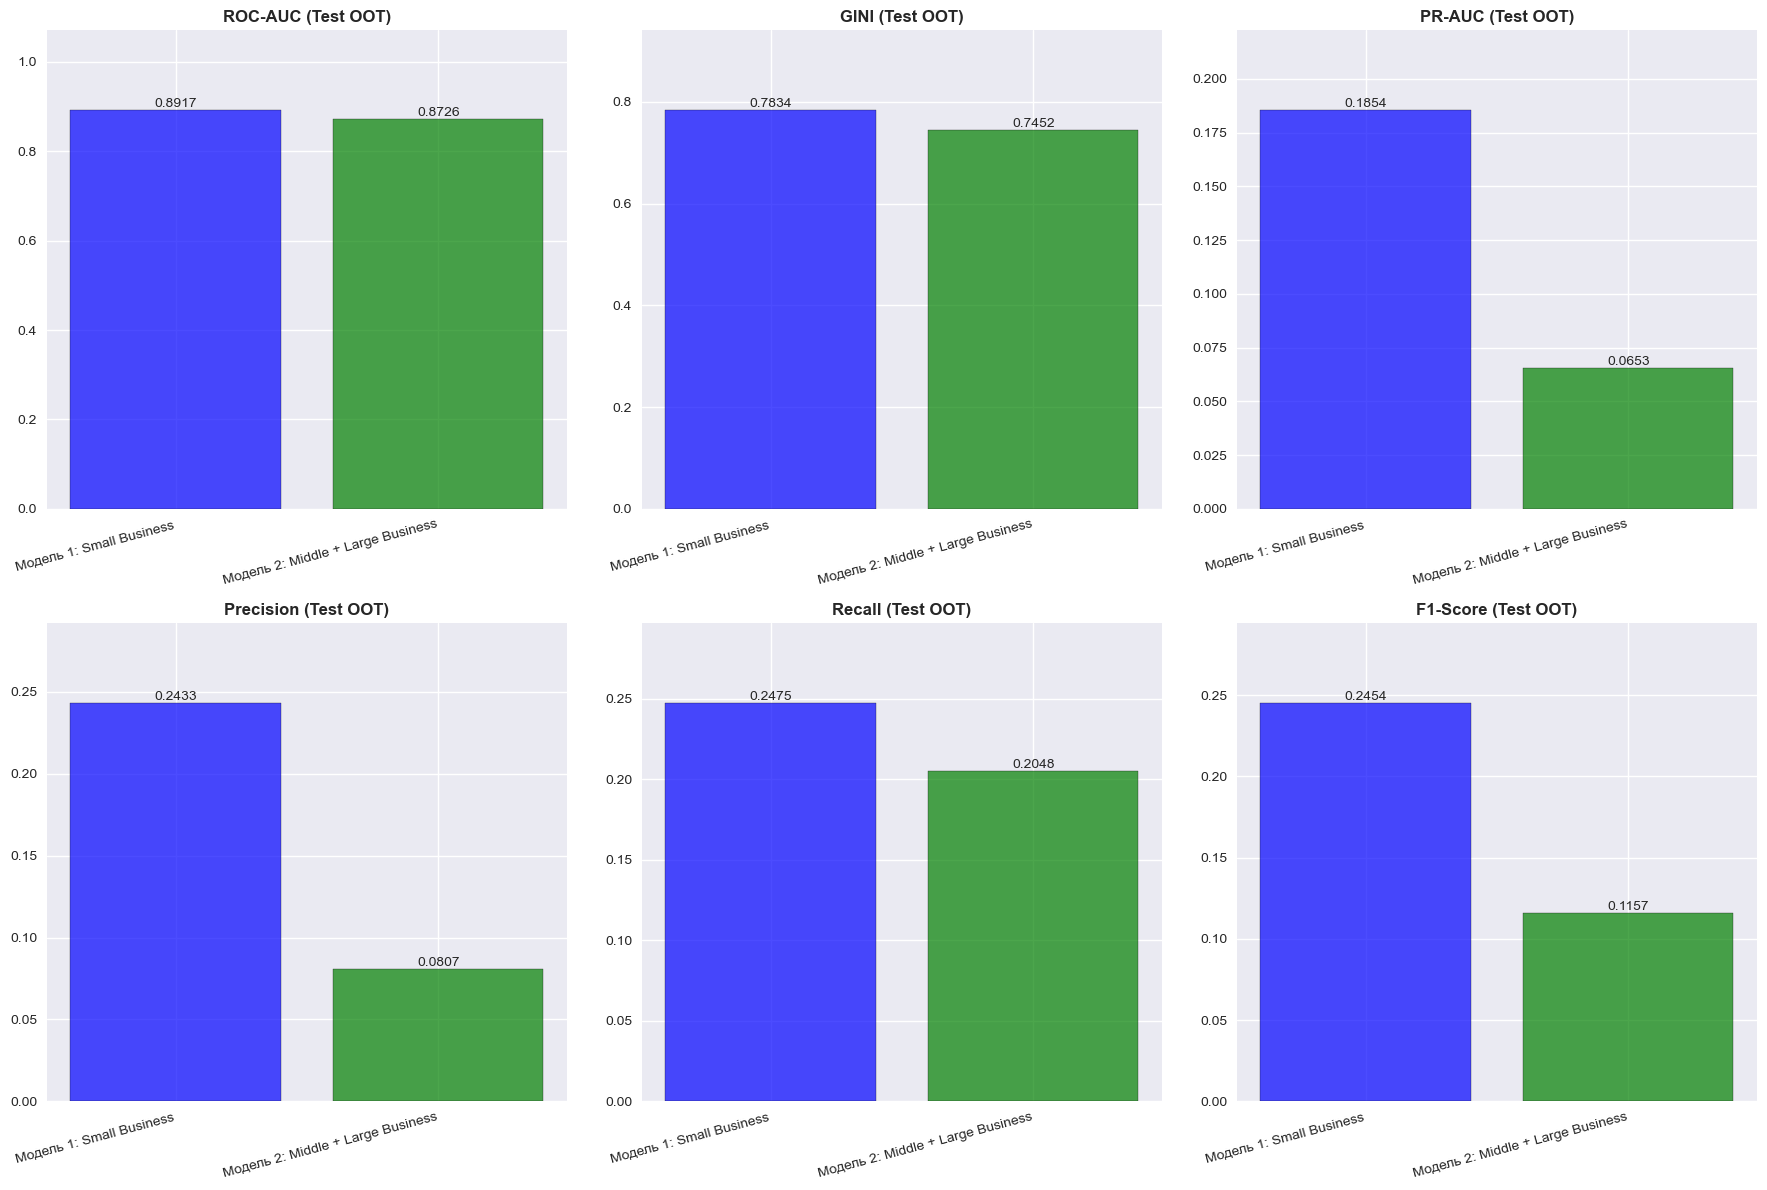


✓ Сохранено: figures/02_models_comparison.png


In [19]:
# ====================================================================================
# ВИЗУАЛИЗАЦИЯ: СРАВНЕНИЕ МОДЕЛЕЙ
# ====================================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

models_data = [
    ("Модель 1: " + config.SEGMENT_1_NAME, test_metrics_1, y_test_1, y_test_pred_proba_1, 'blue'),
    ("Модель 2: " + config.SEGMENT_2_NAME, test_metrics_2, y_test_2, y_test_pred_proba_2, 'green')
]

# Основные метрики
metrics_to_plot = ['roc_auc', 'gini', 'pr_auc', 'precision', 'recall', 'f1']
metric_names = ['ROC-AUC', 'GINI', 'PR-AUC', 'Precision', 'Recall', 'F1-Score']

for idx, metric_key in enumerate(metrics_to_plot):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]

    values = [models_data[0][1][metric_key], models_data[1][1][metric_key]]
    colors = [models_data[0][4], models_data[1][4]]

    bars = ax.bar(range(len(values)), values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels([m[0] for m in models_data], rotation=15, ha='right')
    ax.set_title(f'{metric_names[idx]} (Test OOT)', fontsize=12, fontweight='bold')
    ax.set_ylim(0, max(values) * 1.2)

    for i, v in enumerate(values):
        ax.text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / '02_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Сохранено: figures/02_models_comparison.png")


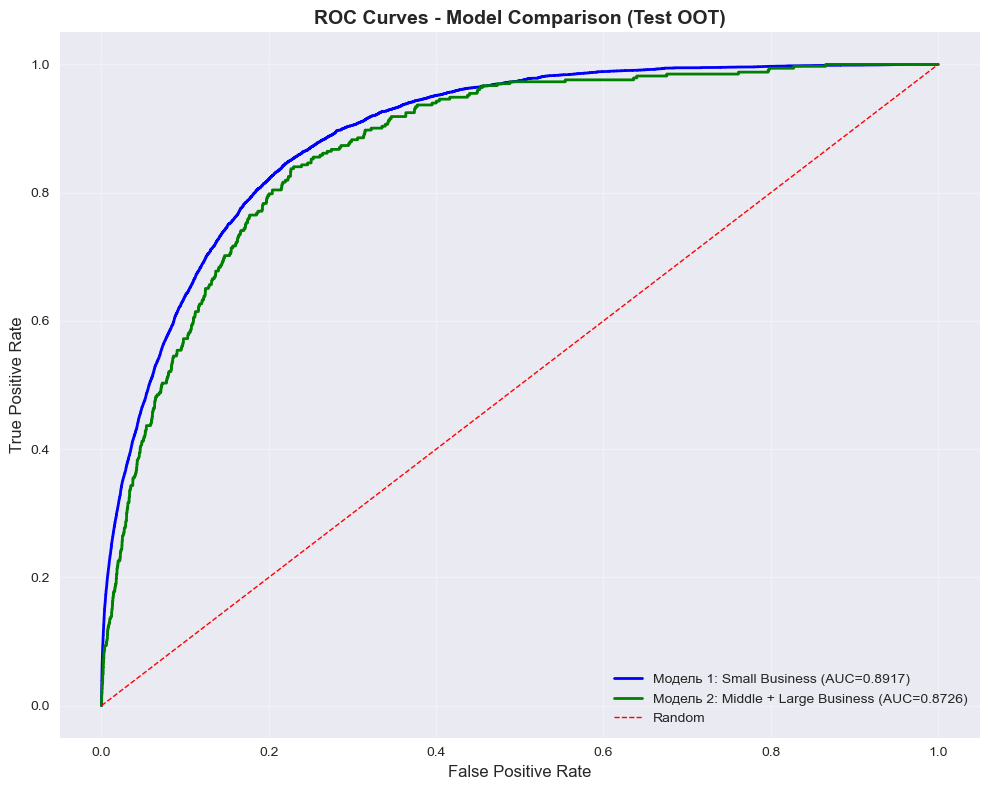

✓ Сохранено: figures/03_roc_curves_comparison.png


In [20]:
# ====================================================================================
# ROC CURVES
# ====================================================================================

fig, ax = plt.subplots(figsize=(10, 8))

for model_name, metrics, y_true, y_pred_proba, color in models_data:
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = metrics['roc_auc']

    ax.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={auc:.4f})',
            color=color)

ax.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Model Comparison (Test OOT)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / '03_roc_curves_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Сохранено: figures/03_roc_curves_comparison.png")


---
# 11. ФИНАЛЬНЫЕ МЕТРИКИ ДЛЯ ОТЧЕТА БАНКУ


In [21]:
# ====================================================================================
# ИТОГОВЫЙ ОТЧЕТ
# ====================================================================================

print("\n" + "="*80)
print("ИТОГОВЫЙ ОТЧЕТ ДЛЯ БАНКА")
print("="*80)

print(f"\nДата создания: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Random seed: {config.RANDOM_SEED}")
print(f"Алгоритм: CatBoost")

print(f"\n{'='*80}")
print("МОДЕЛЬ 1: " + config.SEGMENT_1_NAME.upper())
print(f"{'='*80}")
print(f"Сегмент: {', '.join(config.SEGMENT_1_VALUES)}")
print(f"Train samples: {len(X_train_1):,}")
print(f"Test samples (OOT): {len(X_test_1):,}")
print(f"Test churn rate: {y_test_1.mean()*100:.2f}%")
print(f"Optimal threshold: {optimal_threshold_1:.3f}")

print(f"\nМЕТРИКИ (Test OOT):")
print(f"  ROC-AUC:    {test_metrics_1['roc_auc']:.4f}")
print(f"  GINI:       {test_metrics_1['gini']:.4f}")
print(f"  PR-AUC:     {test_metrics_1['pr_auc']:.4f}")
print(f"  Accuracy:   {test_metrics_1['accuracy']:.4f}")
print(f"  Precision:  {test_metrics_1['precision']:.4f}")
print(f"  Recall:     {test_metrics_1['recall']:.4f}")
print(f"  F1-Score:   {test_metrics_1['f1']:.4f}")

print(f"\nCONFUSION MATRIX:")
print(f"  TN: {test_metrics_1['tn']:>8,}  |  FP: {test_metrics_1['fp']:>8,}")
print(f"  FN: {test_metrics_1['fn']:>8,}  |  TP: {test_metrics_1['tp']:>8,}")

print(f"\n{'='*80}")
print("МОДЕЛЬ 2: " + config.SEGMENT_2_NAME.upper())
print(f"{'='*80}")
print(f"Сегмент: {', '.join(config.SEGMENT_2_VALUES)}")
print(f"Train samples: {len(X_train_2):,}")
print(f"Test samples (OOT): {len(X_test_2):,}")
print(f"Test churn rate: {y_test_2.mean()*100:.2f}%")
print(f"Optimal threshold: {optimal_threshold_2:.3f}")

print(f"\nМЕТРИКИ (Test OOT):")
print(f"  ROC-AUC:    {test_metrics_2['roc_auc']:.4f}")
print(f"  GINI:       {test_metrics_2['gini']:.4f}")
print(f"  PR-AUC:     {test_metrics_2['pr_auc']:.4f}")
print(f"  Accuracy:   {test_metrics_2['accuracy']:.4f}")
print(f"  Precision:  {test_metrics_2['precision']:.4f}")
print(f"  Recall:     {test_metrics_2['recall']:.4f}")
print(f"  F1-Score:   {test_metrics_2['f1']:.4f}")

print(f"\nCONFUSION MATRIX:")
print(f"  TN: {test_metrics_2['tn']:>8,}  |  FP: {test_metrics_2['fp']:>8,}")
print(f"  FN: {test_metrics_2['fn']:>8,}  |  TP: {test_metrics_2['tp']:>8,}")

print("\n" + "="*80)



ИТОГОВЫЙ ОТЧЕТ ДЛЯ БАНКА

Дата создания: 2025-11-13 21:15:49
Random seed: 42
Алгоритм: CatBoost

МОДЕЛЬ 1: SMALL BUSINESS
Сегмент: SMALL_BUSINESS
Train samples: 2,024,010
Test samples (OOT): 500,370
Test churn rate: 1.50%
Optimal threshold: 0.880

МЕТРИКИ (Test OOT):
  ROC-AUC:    0.8917
  GINI:       0.7834
  PR-AUC:     0.1854
  Accuracy:   0.9771
  Precision:  0.2433
  Recall:     0.2475
  F1-Score:   0.2454

CONFUSION MATRIX:
  TN:  487,050  |  FP:    5,794
  FN:    5,663  |  TP:    1,863

МОДЕЛЬ 2: MIDDLE + LARGE BUSINESS
Сегмент: MIDDLE_BUSINESS, LARGE_BUSINESS
Train samples: 129,397
Test samples (OOT): 42,532
Test churn rate: 0.78%
Optimal threshold: 0.860

МЕТРИКИ (Test OOT):
  ROC-AUC:    0.8726
  GINI:       0.7452
  PR-AUC:     0.0653
  Accuracy:   0.9756
  Precision:  0.0807
  Recall:     0.2048
  F1-Score:   0.1157

CONFUSION MATRIX:
  TN:   41,425  |  FP:      775
  FN:      264  |  TP:       68



---
# 12. СОХРАНЕНИЕ МОДЕЛЕЙ И РЕЗУЛЬТАТОВ


In [22]:
# ====================================================================================
# СОХРАНЕНИЕ МОДЕЛЕЙ
# ====================================================================================

print("\n" + "="*80)
print("СОХРАНЕНИЕ МОДЕЛЕЙ И РЕЗУЛЬТАТОВ")
print("="*80)

# Модель 1
model_1_path = config.MODEL_DIR / "model_1_small_business.cbm"
model_1.save_model(model_1_path)
print(f"\n✓ Модель 1 сохранена: {model_1_path}")

# Модель 2
model_2_path = config.MODEL_DIR / "model_2_middle_large_business.cbm"
model_2.save_model(model_2_path)
print(f"✓ Модель 2 сохранена: {model_2_path}")

# Метаданные модели 1
metadata_1 = {
    'model_name': config.SEGMENT_1_NAME,
    'segments': config.SEGMENT_1_VALUES,
    'created_date': datetime.now().isoformat(),
    'random_seed': config.RANDOM_SEED,
    'algorithm': 'CatBoost',
    'catboost_params': config.CATBOOST_PARAMS,
    'train_samples': len(X_train_1),
    'test_samples': len(X_test_1),
    'features': X_train_1.columns.tolist(),
    'categorical_features': config.CATEGORICAL_FEATURES,
    'optimal_threshold': float(optimal_threshold_1),
    'test_metrics': {k: float(v) if isinstance(v, (int, float, np.number)) else v
                    for k, v in test_metrics_1.items()},
    'class_weights': {'class_0': float(w0_1), 'class_1': float(w1_1)} if config.USE_CLASS_WEIGHTS else None
}

metadata_1_path = config.MODEL_DIR / "model_1_metadata.json"
with open(metadata_1_path, 'w', encoding='utf-8') as f:
    json.dump(metadata_1, f, indent=2, ensure_ascii=False)
print(f"✓ Метаданные модели 1: {metadata_1_path}")

# Метаданные модели 2
metadata_2 = {
    'model_name': config.SEGMENT_2_NAME,
    'segments': config.SEGMENT_2_VALUES,
    'created_date': datetime.now().isoformat(),
    'random_seed': config.RANDOM_SEED,
    'algorithm': 'CatBoost',
    'catboost_params': config.CATBOOST_PARAMS,
    'train_samples': len(X_train_2),
    'test_samples': len(X_test_2),
    'features': X_train_2.columns.tolist(),
    'categorical_features': config.CATEGORICAL_FEATURES,
    'optimal_threshold': float(optimal_threshold_2),
    'test_metrics': {k: float(v) if isinstance(v, (int, float, np.number)) else v
                    for k, v in test_metrics_2.items()},
    'class_weights': {'class_0': float(w0_2), 'class_1': float(w1_2)} if config.USE_CLASS_WEIGHTS else None
}

metadata_2_path = config.MODEL_DIR / "model_2_metadata.json"
with open(metadata_2_path, 'w', encoding='utf-8') as f:
    json.dump(metadata_2, f, indent=2, ensure_ascii=False)
print(f"✓ Метаданные модели 2: {metadata_2_path}")

# Comparison table
comparison_df.to_csv(config.OUTPUT_DIR / "models_comparison.csv", index=False)
print(f"✓ Таблица сравнения: {config.OUTPUT_DIR / 'models_comparison.csv'}")

# Preprocessing pipeline
pipeline_path = config.MODEL_DIR / "preprocessing_pipeline.pkl"
with open(pipeline_path, 'wb') as f:
    pickle.dump(pipeline, f)
print(f"✓ Preprocessing pipeline: {pipeline_path}")

print("\n" + "="*80)
print("✓ ВСЕ МОДЕЛИ И РЕЗУЛЬТАТЫ СОХРАНЕНЫ")
print("="*80)

print(f"\nФайлы:")
print(f"  Модели:")
print(f"    - {model_1_path}")
print(f"    - {model_2_path}")
print(f"  Метаданные:")
print(f"    - {metadata_1_path}")
print(f"    - {metadata_2_path}")
print(f"  Результаты:")
print(f"    - {config.OUTPUT_DIR / 'models_comparison.csv'}")
print(f"  Preprocessing:")
print(f"    - {pipeline_path}")
print(f"  Визуализации:")
print(f"    - {config.FIGURES_DIR}")



СОХРАНЕНИЕ МОДЕЛЕЙ И РЕЗУЛЬТАТОВ

✓ Модель 1 сохранена: models\model_1_small_business.cbm
✓ Модель 2 сохранена: models\model_2_middle_large_business.cbm
✓ Метаданные модели 1: models\model_1_metadata.json
✓ Метаданные модели 2: models\model_2_metadata.json
✓ Таблица сравнения: output\models_comparison.csv
✓ Preprocessing pipeline: models\preprocessing_pipeline.pkl

✓ ВСЕ МОДЕЛИ И РЕЗУЛЬТАТЫ СОХРАНЕНЫ

Файлы:
  Модели:
    - models\model_1_small_business.cbm
    - models\model_2_middle_large_business.cbm
  Метаданные:
    - models\model_1_metadata.json
    - models\model_2_metadata.json
  Результаты:
    - output\models_comparison.csv
  Preprocessing:
    - models\preprocessing_pipeline.pkl
  Визуализации:
    - figures


In [23]:
# ====================================================================================
# ФИНАЛ
# ====================================================================================

print("\n\n" + "="*80)
print("✓✓✓ ПОСТРОЕНИЕ МОДЕЛЕЙ ЗАВЕРШЕНО УСПЕШНО ✓✓✓")
print("="*80)

print("\nИтоговые метрики (Test OOT):")
print(f"\n{config.SEGMENT_1_NAME}:")
print(f"  GINI: {test_metrics_1['gini']:.4f} | ROC-AUC: {test_metrics_1['roc_auc']:.4f} | F1: {test_metrics_1['f1']:.4f}")

print(f"\n{config.SEGMENT_2_NAME}:")
print(f"  GINI: {test_metrics_2['gini']:.4f} | ROC-AUC: {test_metrics_2['roc_auc']:.4f} | F1: {test_metrics_2['f1']:.4f}")

print("\n" + "="*80)
print("Воспроизводимость: Run All → идентичные результаты (random_seed=42)")
print("="*80)




✓✓✓ ПОСТРОЕНИЕ МОДЕЛЕЙ ЗАВЕРШЕНО УСПЕШНО ✓✓✓

Итоговые метрики (Test OOT):

Small Business:
  GINI: 0.7834 | ROC-AUC: 0.8917 | F1: 0.2454

Middle + Large Business:
  GINI: 0.7452 | ROC-AUC: 0.8726 | F1: 0.1157

Воспроизводимость: Run All → идентичные результаты (random_seed=42)
